# Mask R-CNN - Trained WorkTool Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.
- Note: Code adapted from project https://github.com/matterport/Mask_RCNN 

In [1]:
# Run this block to connect to your google drive
# folder structure: VSE/CA1

from google.colab import drive
drive.mount('/content/gdrive')

# Change working directory to be current folder, please keep ''/content/gdrive/My Drive/XXX' in the path and change XXX to be your own folder.
# The path is case sensitive.
import os
os.chdir('/content/gdrive/My Drive/VSE/CA1')
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
augmentation		      mask_rcnn_coco.h5
datasets		      model.py
google_drive.jpg	      __pycache__
inspect_worktool_data.html    readme.txt
inspect_worktool_data.ipynb   train_worktool_model_colab.html
inspect_worktool_model.html   train_worktool_model_colab.ipynb
inspect_worktool_model.ipynb  worktool.py
logs


In [2]:
import os
import sys
import random
import math
import re
import time
import numpy as np

%tensorflow_version 1.x #inform google colab to fall back to tensorflow 1.x
import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

import model as modellib
from model import log

# Import visualization functions    
from model import display_instances, display_images, draw_boxes #, display_top_masks
#from model import  random_colors, draw_rois, draw_box

# Import utility functions
from model import apply_box_deltas, denorm_boxes, non_max_suppression, denorm_boxes, unmold_mask

import worktool

from IPython.display import Image


%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")


`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x #inform google colab to fall back to tensorflow 1.x`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


Using TensorFlow backend.


## Configurations

In [3]:
config = worktool.WorkToolConfig()
WORKTOOL_DIR = os.path.join(ROOT_DIR, "datasets")

# Make sure you set it to 1 BG + the number of classes you are predicting
# See worktool.py
print("Number of classes: ", config.NUM_CLASSES)


Number of classes:  3


In [4]:
# Training configurations 
# Main settings for training

config.IMAGES_PER_GPU = 1    
config.GPU_COUNT = 1
config.MINI_MASK_SHAPE = (640, 640)
config.DETECTION_MIN_CONFIDENCE = 0.7
config.POST_NMS_ROIS_TRAINING = 2000
config.IMAGE_MIN_DIM = 640
config.VALIDATION_STEPS = 80

config.display()



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  640
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTA

## Notebook Preferences

In [0]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "training"


In [0]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load  Dataset

In [7]:
# Load training dataset
dataset_train = worktool.WorkToolDataset()
dataset_train.load_worktool(WORKTOOL_DIR, "train")
dataset_train.prepare() # Must call before using the dataset

# Load validation dataset
dataset_val = worktool.WorkToolDataset()
dataset_val.load_worktool(WORKTOOL_DIR, "val")
dataset_val.prepare() # Must call before using the dataset

print("Training Images: {}\nClasses: {}".format(len(dataset_train.image_ids), dataset_train.class_names))
print("Test Images: {}\nClasses: {}".format(len(dataset_val.image_ids), dataset_val.class_names))


Training Images: 416
Classes: ['BG', 'hammer', 'spanner']
Test Images: 26
Classes: ['BG', 'hammer', 'spanner']


## Ceate Model

In [8]:
Num_of_Epochs = 100
print("Training model for " + str(Num_of_Epochs) + " epochs")

Training model for 100 epochs


In [9]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Load weights trained on MS COCO, but skip layers that
# are different due to the different number of classes
# See README for instructions to download the COCO weights
model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])

# *** This training schedule is an example. Update to your needs ***
# no need to train all layers, just the heads should do it.
print("Training network heads")
model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=Num_of_Epochs,
                layers='heads')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead
Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: /content/gdrive/My Drive/VSE/CA1/logs/worktool20200416T1436/mask_rcnn_worktool_new.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_con

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/100
100/100 [==============================] - 66s 664ms/step - loss: 1.0627 - val_loss: 0.6890

Epoch 2/100
100/100 [==============================] - 50s 499ms/step - loss: 0.7288 - val_loss: 1.6576
Epoch 3/100
100/100 [==============================] - 52s 518ms/step - loss: 0.5441 - val_loss: 0.4331
Epoch 4/100
100/100 [==============================] - 50s 502ms/step - loss: 0.4972 - val_loss: 0.9776
Epoch 5/100
100/100 [==============================] - 52s 517ms/step - loss: 0.5131 - val_loss: 0.6245
Epoch 6/100
100/100 [==============================] - 51s 506ms/step - loss: 0.6403 - val_loss: 1.2351
Epoch 7/100
100/100 [==============================] - 50s 496ms/step - loss: 0.7367 - val_loss: 0.6985
Epoch 8/100
100/100 [==============================] - 52s 515ms/step - loss: 0.5733 - val_loss: 0.5913
Epoch 9/100
100/100 [==============================] - 51s 513ms/step - loss: 0.3714 - val_loss: 0.3192
Epoch 10/100
100/100 [==============================] - 52s 516

## Trained Model
- ### Model Name: 'mask_rcnn_worktool_new.h5' is located in the logs folder
- located this on your Google Drive at: VSE / CA1 / logs
- Rename the model to 'mask_rcnn_worktool.h5' and download to your locate project's root folder
- Run inference test with this model weights using the notebook 'inspect_worktool_model.ipynb'

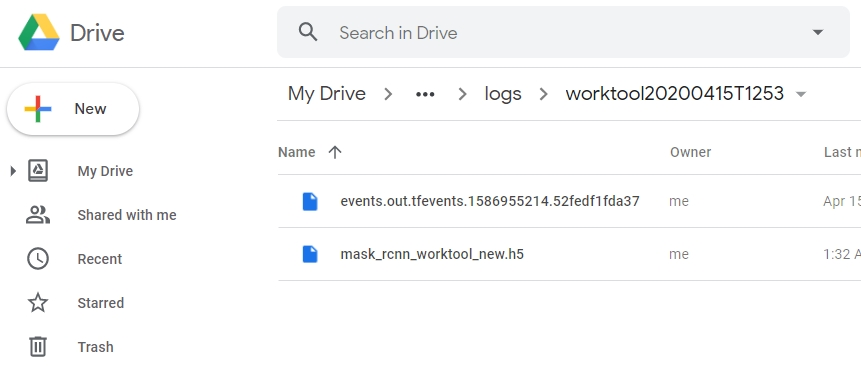

In [0]:

Image(ROOT_DIR+'/google_drive.jpg')